## Objective
For each matched unit of two sorters, create 3 bold waveform plots
where all spikes are plotted and the average (template) is bolded
    1. Spikes that match
    2. Spikes detected only by sorter 1
    3. Spikes detected only by sorter 2

In [53]:
# region Set up notebook imports
%load_ext autoreload
%autoreload 2
# Allow for imports of other scripts
import sys
PATH = "/data/MEAprojects/PropSignal"
if PATH not in sys.path:
    sys.path.append(PATH)
# Reload a module after changes have been made
from importlib import reload
# endregion

import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
import sys
from pathlib import Path
from tqdm import tqdm

from src import utils
from src.recording import Recording
from src.sorters.prop_signal import PropSignal
from src.sorters.kilosort import Kilosort
from src.comparison import Comparison

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
recording = Recording(utils.PATH_REC_SI, freq_min=300, freq_max=6000)

/home/mea/anaconda3/envs/allen_inst/lib/python3.7/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.5.1 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
/home/mea/anaconda3/envs/allen_inst/lib/python3.7/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.5.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
/home/mea/anaconda3/envs/allen_inst/lib/python3.7/site-packages/pynwb/ecephys.py:93: UserWarning: ElectricalSeries 'ElectricalSeries': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  "Your data may be transposed." % (self.__class__.__name__, kwargs["name"]))


In [35]:
# Load sorter1
sorter1 = PropSignal("/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/updated", recording)

In [36]:
# Load sorter2
sorter2 = Kilosort(utils.PATH_SM4_SI, "first", recording)

Getting spike times
Getting match counts and agreement scores


100%|██████████| 141/141 [00:26<00:00,  5.24it/s]


Matches/Num Kilosort2: 71/339


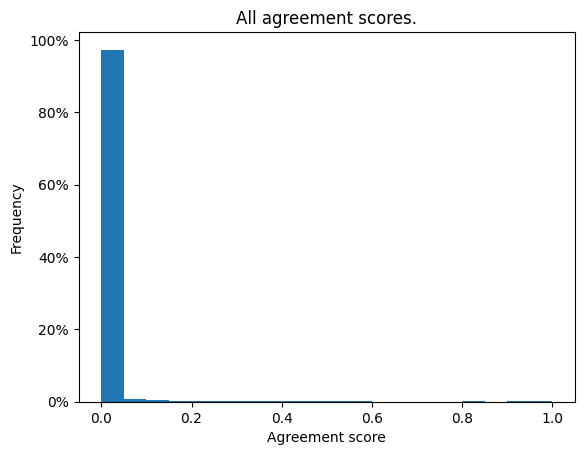

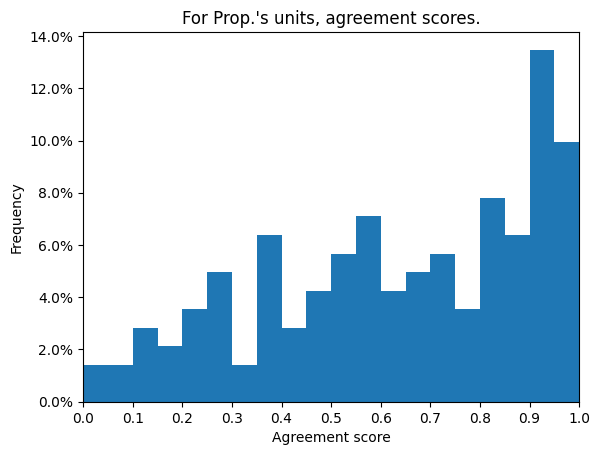

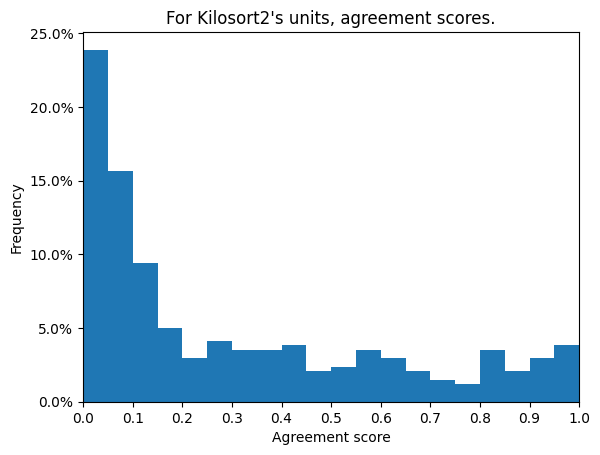

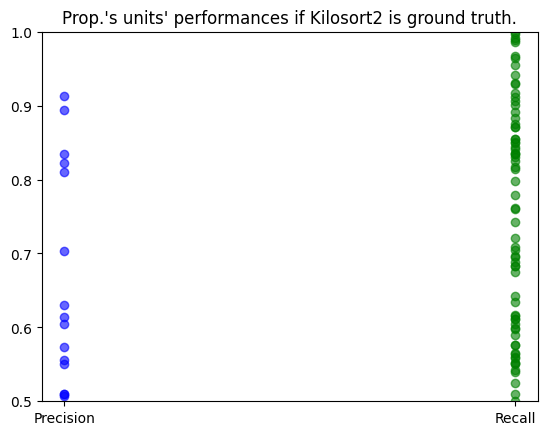

In [37]:
# Comparison
comparison = Comparison(sorter1, sorter2)

In [7]:
comparison.agreement_scores.shape

(141, 339)

In [8]:
scores = comparison.agreement_scores
scores = scores[np.max(scores, axis=1) >= 0.5, :]
match = np.argmax(scores, axis=1)
print(match.shape)
print(np.unique(match).shape)

(97,)
(43,)


In [163]:
"""
Match each sorter1 unit with sorter2 unit with highest agreement score
"""
units1 = sorter1.get_spike_times()
units2 = sorter2.get_spike_times()
idx_12 = np.argmax(comparison.agreement_scores, axis=1)
units_scores = comparison.agreement_scores[np.arange(len(idx_12)), idx_12]

In [21]:
def get_matching_spikes(times1, times2, delta=0.4):
    matched = []
    unmatched1 = []

    already_matched = set()
    for st1 in times1:
        idx = np.searchsorted(times2, st1)
        idx_left = idx - 1
        while idx_left in already_matched:
            idx_left -= 1
        if idx_left >= 0:
            left = times2[idx_left]
        else:
            left = -np.inf

        idx_right = idx
        while idx_right in already_matched:
            idx_right += 1
        if idx_right < len(times2):
            right = times2[idx_right]
        else:
            right = np.inf

        if right - st1 < st1 - left:
            if right - st1 <= delta:
                matched.append(st1)
                already_matched.add(idx_right)
            else:
                unmatched1.append(st1)
        else:
            if st1 - left <= delta:
                matched.append(st1)
                already_matched.add(idx_left)
            else:
                unmatched1.append(st1)

    unmatched2 = [times2[i] for i in range(len(times2)) if i not in already_matched]

    return matched, unmatched1, unmatched2

In [8]:
# matches = []
# more_spikes1 = 0
# more_spikes2 = 0
# for times1, times2 in zip(comparison.spike_times_matching1, comparison.spike_times_matching2):
#     if len(times1) > len(times2):
#         more_spikes1 += 1
#     else:
#         more_spikes2 += 1
#     matches.append(get_matching_spikes(times1, times2))
# print(more_spikes1, more_spikes2)

14 23


In [39]:
matches = []
for i1, i2 in enumerate(idx_12):
    matches.append(get_matching_spikes(units1[i1], units2[i2]))

In [131]:
N_BEFORE = int(2 * recording.get_sampling_frequency())
N_AFTER = int(2 * recording.get_sampling_frequency())
N_CHANS = len(recording.get_channel_locations())
SAVE_PATH = Path("/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/updated/max_ks_match")
WF_NAMES = ["matched.npy", "unmatched1.npy", "unmatched2.npy"]

sf = recording.get_sampling_frequency()
def extract_templates(idx):
    # idx is idx in matches
    # matched, unmatched1, unmatched2 = matches[idx]
    save_path = SAVE_PATH / str(idx)
    save_path.mkdir(parents=True, exist_ok=True)

    for name, spike_times in zip(WF_NAMES, matches[idx]):
        if len(spike_times) == 0:
            np.save(save_path / name, [0])
            continue

        temp = np.zeros((len(spike_times), N_CHANS, N_BEFORE + 1 + N_AFTER), dtype="float32")
        for i, st in enumerate(spike_times):
            st = int(st * sf)
            temp[i, :, :] = recording.get_traces_filt(st-N_BEFORE, st+N_AFTER+1)
        np.save(save_path / name, temp)
    return None

np.save(SAVE_PATH / "idx_12.npy", idx_12)

In [59]:
# # Extract waveforms
# with Pool(processes=22) as pool:
#     tasks = range(len(matches))
#     for _ in tqdm(pool.imap(extract_templates, tasks), total=len(tasks)):
#         pass

100%|██████████| 141/141 [25:09<00:00, 10.71s/it] 


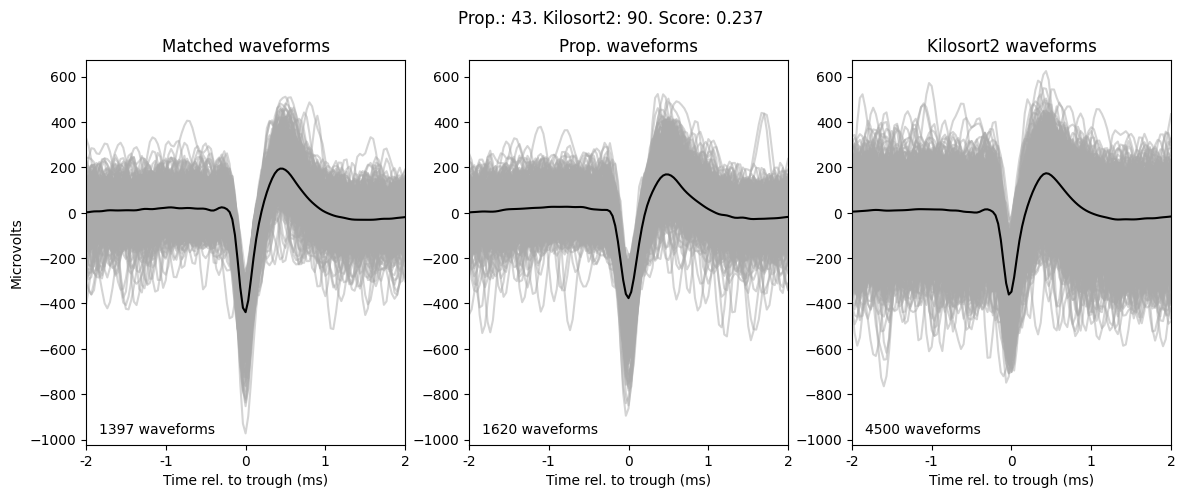

In [173]:
class Waveform:
    def __init__(self, idx):
        self.idx = idx

        path = SAVE_PATH / str(idx)
        self.path = path
        self.matched = np.load(path / WF_NAMES[0], mmap_mode="r")
        self.unmatched1 = np.load(path / WF_NAMES[1], mmap_mode="r")
        self.unmatched2 = np.load(path / WF_NAMES[2], mmap_mode="r")
        self.waveforms = (self.matched, self.unmatched1, self.unmatched2)

        self.unit1 = units1[idx]
        self.unit2 = units2[idx]
        self.score = units_scores[idx]

        self.chan = sorter1.props[idx][0].ID[0]

    def plot(self, save=False):
        TICK_LABELS = np.array([-2, -1, 0, 1, 2])
        YLIM_BUFFER = 50
        SUBPLOTS_NAMES = (f"Matched waveforms", sorter1.name + " waveforms", sorter2.name + " waveforms")

        fig, subplots = plt.subplots(1, 3, figsize=(14, 5))

        y_min, y_max = np.inf, -np.inf
        for a, waveforms in zip(subplots, self.waveforms):
            if len(waveforms.shape) != 3: continue

            waveforms = waveforms[:, self.chan, :]
            template = np.mean(waveforms, axis=0)
            a.plot(waveforms.T, c="#aaaaaa", alpha=0.5)
            a.plot(template, c="black")

            y_min = min(y_min, np.min(waveforms))
            y_max = max(y_max, np.max(waveforms))

        subplots[0].set_ylabel("Microvolts")
        for name, a, waveforms in zip(SUBPLOTS_NAMES, subplots, self.waveforms):
            ticks = TICK_LABELS * sf + self.matched.shape[2]//2
            a.set_xticks(ticks)
            a.set_xticklabels(TICK_LABELS)
            a.set_xlim(ticks[0], ticks[-1])
            a.set_xlabel("Time rel. to trough (ms)")
            a.set_ylim(y_min-YLIM_BUFFER, y_max+YLIM_BUFFER)
            a.set_title(name)
            a.text(5, y_min, f"{len(waveforms) if len(waveforms.shape) == 3 else 0} waveforms")

        fig.suptitle(f"{sorter1.name}: {self.idx}. {sorter2.name}: {idx_12[self.idx]}. Score: {self.score:.3f}")

        if isinstance(save, bool):
            if not save:
                plt.show()
            else:
                plt.savefig(self.path / "plot.png")
                plt.close(fig)
        else:
            plt.savefig(save)
            plt.close(fig)
waveform = Waveform(43)
waveform.plot(save=False)

In [174]:
save_path = SAVE_PATH / "plots"
save_path.mkdir(parents=True, exist_ok=True)
for idx in tqdm(range(50, len(matches))):
    Waveform(idx).plot(save=save_path / (str(idx) + ".png"))

100%|██████████| 91/91 [16:29<00:00, 10.87s/it]
